In [8]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc import adia_analysis
from Circuit_Simulator._util import *
from Circuit_Simulator.Qobj import *

In [2]:
# x=np.linspace(-10,10,1000)
# np.sinc(x)
# plt.plot(x,np.sinc(x))

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8200.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '126.2569MHz', 'g13': '8.5381MHz', 'g23': '119.7778MHz'}


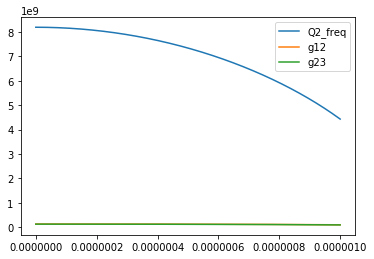

In [9]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='basis',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0,0.4,1001)
# freq_array = 8.2e9-flux_pulse * (8.2e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.00e9)
raw_config.setValue('Q2 f01_max',8.2e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.3e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',1)
raw_config.setValue('Q2 Voltage operating point',0.0)
raw_config.setValue('Q2 Flux',flux_pulse)


simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

In [10]:
Simulator.performsimulation(solver_type=2,resample_factor=1,get_cloest_eigen=False,sort_by_maximum_overlap=True,gap=16e6)

In [11]:
eigenstate010 = Simulator.EigenResult.eigen_state[:,3]
eigenstate100 = Simulator.EigenResult.eigen_state[:,9]
eigenstate001 = Simulator.EigenResult.eigen_state[:,1]

eigenstate101 = Simulator.EigenResult.eigen_state[:,10]
eigenstate011 = Simulator.EigenResult.eigen_state[:,4]
eigenstate110 = Simulator.EigenResult.eigen_state[:,12]
eigenstate002 = Simulator.EigenResult.eigen_state[:,2]
eigenstate020 = Simulator.EigenResult.eigen_state[:,6]
eigenstate200 = Simulator.EigenResult.eigen_state[:,18]

In [12]:
eigenener010 = Simulator.EigenResult.eigen_ener[:,3]
eigenener100 = Simulator.EigenResult.eigen_ener[:,9]
eigenener001 = Simulator.EigenResult.eigen_ener[:,1]

eigenener101 = Simulator.EigenResult.eigen_ener[:,10]
eigenener011 = Simulator.EigenResult.eigen_ener[:,4]
eigenener110 = Simulator.EigenResult.eigen_state[:,12]
eigenener002 = Simulator.EigenResult.eigen_ener[:,2]
eigenener020 = Simulator.EigenResult.eigen_ener[:,6]
eigenener200 = Simulator.EigenResult.eigen_ener[:,18]

In [18]:
transmon = PG.Transmon(8.2e9, 1e9, 300e6, 1, 0, 0.0)

In [19]:
flux_bias = flux_pulse
freq_arr = transmon.V_to_f(flux_pulse)

## funcs

In [16]:
def get_deriv(y,x):
    if isinstance(x,(float,int )):
        return (y[1:]-y[0:-1])/x
    else:
        return (y[1:]-y[0:-1])/(x[1:]-x[0:-1])

## gamma dephasing

In [20]:
noise_sigma=50e-6

Gamma_dephase_100 = np.abs(get_deriv(eigenener100,flux_bias)*noise_sigma/np.sqrt(2))*2*np.pi
Gamma_dephase_001 = np.abs(get_deriv(eigenener001,flux_bias)*noise_sigma/np.sqrt(2))*2*np.pi
Gamma_dephase_101 = np.abs(get_deriv(eigenener101,flux_bias)*noise_sigma/np.sqrt(2))*2*np.pi


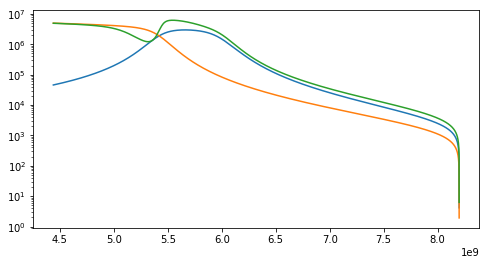

In [21]:
fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(111)
ax.plot(freq_arr[0:-1],Gamma_dephase_100)
ax.plot(freq_arr[0:-1],Gamma_dephase_001)
ax.plot(freq_arr[0:-1],Gamma_dephase_101)
ax.set_yscale('log')

## gamma intra-band leakage

In [25]:
def get_leakage_factor(main_trace_index,leakage_trace_index,d_flux):
    eigenstate_main = Simulator.EigenResult.eigen_state[:,main_trace_index]
    eigenstate_leak = Simulator.EigenResult.eigen_state[:,leakage_trace_index]
    eigenener_main = Simulator.EigenResult.eigen_ener[:,main_trace_index]*2*np.pi
    eigenener_leak= Simulator.EigenResult.eigen_ener[:,leakage_trace_index]*2*np.pi
    eigenstate_main_smooth = adia_analysis.smooth_state_trace(eigenstate_main)
    eigenstate_main_deriv = (eigenstate_main_smooth[1:]-eigenstate_main_smooth[0:-1])/d_flux
    leak_main_to_leak = []
    for i in range(len(eigenstate_main_deriv)):
        leak_main_to_leak.append(  abs(eigenener_main[i]-eigenener_leak[i])**2 * ( np.dot(eigenstate_leak[i].T,eigenstate_main_deriv[i]) )**2  )
    return np.array(leak_main_to_leak)

def S_w(A,w_gap):
    return np.abs(A/w_gap)

def get_Gamma(A,main_trace_index,leakage_trace_index,df,EigenResult):
    return get_leakage_factor(main_trace_index,leakage_trace_index,df)*S_w(A,EigenResult.eigen_ener[0:-1,main_trace_index]*2*np.pi-EigenResult.eigen_ener[0:-1,leakage_trace_index]*2*np.pi)

In [26]:
A = (20e-6)**2
d_flux = flux_bias[1] - flux_bias[0]
Gamma_001_010 = get_Gamma(A,1,3,d_flux,Simulator.EigenResult)
Gamma_100_010 = get_Gamma(A,9,3,d_flux,Simulator.EigenResult)
Gamma_100_001 = get_Gamma(A,9,1,d_flux,Simulator.EigenResult)

Gamma_101_002 = get_Gamma(A,10,2,d_flux,Simulator.EigenResult)
Gamma_101_020 = get_Gamma(A,10,6,d_flux,Simulator.EigenResult)
Gamma_101_200 = get_Gamma(A,10,18,d_flux,Simulator.EigenResult)
Gamma_101_011 = get_Gamma(A,10,4,d_flux,Simulator.EigenResult)
Gamma_101_110 = get_Gamma(A,10,12,d_flux,Simulator.EigenResult)

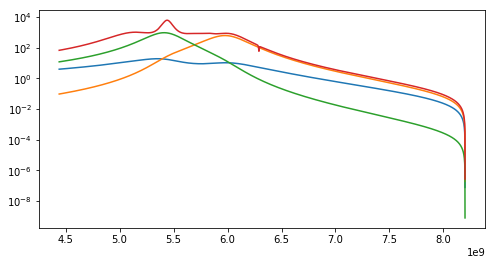

In [28]:
fig=plt.figure(figsize=[8,4])
ax=fig.add_subplot(111)
ax.plot(freq_arr[0:-1],np.abs(Gamma_001_010))
ax.plot(freq_arr[0:-1],np.abs(Gamma_100_010))
ax.plot(freq_arr[0:-1],np.abs(Gamma_100_001))
ax.plot(freq_arr[0:-1],np.abs(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110))

ax.set_yscale('log')

In [17]:
%matplotlib qt

## Gamma inner-band leakage

In [29]:
import qutip as qt
lambda_coupler = 4.08e-3
lambda_q1 = 2.88e-3
lambda_q2 = 2.88e-3
kB = 1.380649*10**(-23)
Hbar = 6.62607015*10**(-34) 

def get_T1(mat_factor,f,Temper=0.02):
    heat_parameter =0.5*( 1/np.tanh(Hbar*f/(kB*Temper)) +1 )
    return 1/(mat_factor**2*6e9*heat_parameter)

def get_T1_Gamma(mat_factor,f,Temper=0.02):
    heat_parameter =0.5*( 1/np.tanh(Hbar*f/(kB*Temper)) +1 )
    return mat_factor**2*6e9*heat_parameter

def get_operator(lambda_q1,lambda_q2,lambda_coupler):
    a1_a =qt.tensor( lambda_q1 * ( qt.create(3)+ qt.destroy(3) ),qt.qeye(3),qt.qeye(3)  )
    ac_a =qt.tensor( qt.qeye(3), lambda_coupler * ( qt.create(3)+ qt.destroy(3)),qt.qeye(3)  )
    a2_a =qt.tensor( qt.qeye(3),qt.qeye(3),lambda_q2 * (qt.create(3)+qt.destroy(3))  )
    return Qflatten(a1_a+a2_a+ac_a)

In [30]:
get_T1(4.08e-3,6e9)*1e6

10.01217480455922

In [31]:
get_T1(2.88e-3,6e9)

2.009387860081677e-05

In [32]:
def get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,estate_trace,ener_trace,central_idx,leak_idx):
    leak_oper1 = get_operator( lambda_q1,lambda_q2*0,lambda_coupler*0 )
    leak_oper2 = get_operator( lambda_q1*0,lambda_q2,lambda_coupler*0 )
    leak_oper3 = get_operator( lambda_q1*0,lambda_q2*0,lambda_coupler )
    gamma_arr=[]
    for i in range(len(estate_trace[:,0])):
        gamma1 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper1*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )
        gamma2 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper2*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )
        gamma3 = get_T1_Gamma( (qt.Qobj(estate_trace[i][leak_idx]).dag()* (leak_oper3*qt.Qobj(estate_trace[i][central_idx])))[0][0][0]  , ener_trace[i][central_idx]-ener_trace[i][leak_idx] )
        gamma_arr.append( np.real(gamma1)+np.real(gamma2)+np.real(gamma3) )
    return np.array(gamma_arr)

In [33]:
Decay_001_000 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,1,0  )
Decay_100_000 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,9,0  )
Decay_101_010 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,3  )
Decay_101_100 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,9  )
Decay_101_001 = get_decay_rate(lambda_q1,lambda_q2,lambda_coupler,Simulator.EigenResult.eigen_state,Simulator.EigenResult.eigen_ener,10,1  )


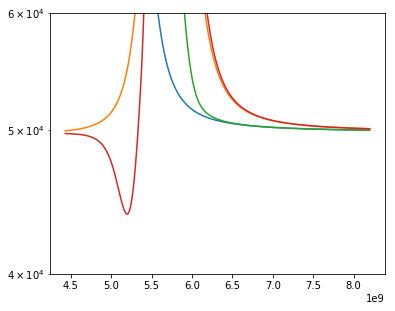

In [34]:
fig=plt.figure(figsize=[6,4.8])
ax=fig.add_subplot(111)
ax.plot(freq_arr,Decay_001_000)
ax.plot(freq_arr,Decay_100_000)
ax.plot(freq_arr,Decay_101_100)
ax.plot(freq_arr,Decay_101_001)
# ax.plot(freq_arr,Decay_101_010)
ax.set_ylim([40e3,60e3])
ax.set_yscale('log')

In [35]:
def formatnum(x, pos):
    return '$%0.1f$x$10^{5}$' % (x/100000)
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(formatnum)
# ax1.yaxis.set_major_formatter(formatter)

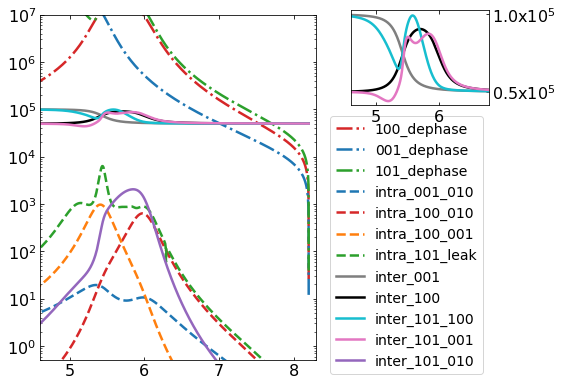

In [36]:
fig=plt.figure(figsize=[8,6.0])
ax= fig.add_axes([0.1,0.1,0.48,0.8])
ax_inset = fig.add_axes([0.64,0.69,0.24,0.22])
lw=2.5
ax.plot(freq_arr[0:-1]/1e9,Gamma_dephase_100*2*np.pi,'-.',c='tab:red',linewidth=lw,label='100_dephase')
ax.plot(freq_arr[0:-1]/1e9,Gamma_dephase_001*2*np.pi,'-.',c='tab:blue',linewidth=lw,label='001_dephase')
ax.plot(freq_arr[0:-1]/1e9,Gamma_dephase_101*2*np.pi,'-.',c='tab:green',linewidth=lw,label='101_dephase')

ax.plot(freq_arr[0:-1]/1e9,np.abs(Gamma_001_010),'--',c='tab:blue',linewidth=lw,label='intra_001_010')
ax.plot(freq_arr[0:-1]/1e9,np.abs(Gamma_100_010),'--',c='tab:red',linewidth=lw,label='intra_100_010')
ax.plot(freq_arr[0:-1]/1e9,np.abs(Gamma_100_001),'--',c='tab:orange',linewidth=lw,label='intra_100_001')
ax.plot(freq_arr[0:-1]/1e9,np.abs(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110),'--',c='tab:green',linewidth=lw,label='intra_101_leak')

ax.plot(freq_arr/1e9,Decay_001_000,'-',c='tab:gray',linewidth=lw,label='inter_001')
ax.plot(freq_arr/1e9,Decay_100_000,'-',c='black',linewidth=lw,label='inter_100')
ax.plot(freq_arr/1e9,Decay_101_100,'-',c='tab:cyan',linewidth=lw,label='inter_101_100')
ax.plot(freq_arr/1e9,Decay_101_001,'-',c='tab:pink',linewidth=lw,label='inter_101_001')
ax.plot(freq_arr/1e9,Decay_101_010,'-',c='tab:purple',linewidth=lw,label='inter_101_010')

ax_inset.plot(freq_arr/1e9,Decay_001_000,'-',c='tab:gray',linewidth=lw)
ax_inset.plot(freq_arr/1e9,Decay_100_000,'-',c='black',linewidth=lw)
ax_inset.plot(freq_arr/1e9,Decay_101_100,'-',c='tab:cyan',linewidth=lw)
ax_inset.plot(freq_arr/1e9,Decay_101_001,'-',c='tab:pink',linewidth=lw)

ax_inset.yaxis.set_label_position("right")
ax_inset.yaxis.set_major_formatter(formatter)
ax_inset.yaxis.tick_right()
# ax_inset.set_yticks([30000,40000])
# ax_inset.set_ylim([3.9e4,6.1e4])
ax_inset.set_xlim([4.6,6.8])

ax.set_yscale('log')
ax.set_xlim([4.6,8.3])
ax.set_ylim([5e-1,10e6])


ax.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax.tick_params(axis='y',which='both',left=True,right=True,direction='in' )
ax_inset.tick_params(axis='x',which='both',top=True,bottom=True,direction='in' )
ax_inset.tick_params(axis='y',which='both',left=True,right=True,direction='in' )

ax.tick_params(labelsize=16)
ax_inset.tick_params(labelsize=16)

ax.legend(fontsize=14,loc=[1.05,-0.04])

In [61]:
%matplotlib qt

In [464]:
transmon = PG.Transmon(8.2e9, 1e9, 300e6, 1, 0, 0.12505)

## contribution to RB errors

In [27]:
Pulse_params_arr = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Pulse_params_arr.txt' )
RB_error = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\RB_error_arr.txt' )
# np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Unitary_error_arr.txt' )
gate_time_arr = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\gate_time_arr.txt' )

In [28]:
lamb1 = Pulse_params_arr[18]
gate_time = gate_time_arr[18]
total_len = gate_time + 10e-9

Seq=PG.Sequence(total_len=total_len,sample_rate=10e9,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),qubit=transmon,Q1_freq=6.0e9,
             CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
             anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=1,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

In [27]:
%matplotlib inline

In [29]:
Spline001_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_001_010))
Spline100_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_100_010))
Spline100_intra_swap = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_100_001))
Spline101_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110))

Spline001_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_001_000))
Spline100_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_100_000))
Spline101_100_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_100))
Spline101_001_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_001))
Spline101_inter_leak = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_010))

In [30]:
a = np.sum( adia_analysis.get_interpolate_value(Spline001_intra_leak,(flux_pulse[41:-40])))*0.1e-9
b = np.sum( adia_analysis.get_interpolate_value(Spline100_intra_leak,(flux_pulse[41:-40])))*0.1e-9
c = np.sum( adia_analysis.get_interpolate_value(Spline101_intra_leak,(flux_pulse[41:-40])))*0.1e-9
d = np.sum( adia_analysis.get_interpolate_value(Spline101_inter_leak,(flux_pulse[41:-40])))*0.1e-9
(a+b+c+d)/4

5.196543310634032e-07

In [31]:
a1 = np.sum( adia_analysis.get_interpolate_value(Spline100_intra_swap,(flux_pulse[41:-40])))*0.1e-9
b1 = np.sum( adia_analysis.get_interpolate_value(Spline001_inter_trans,(flux_pulse[41:-40])))*0.1e-9
c1 = np.sum( adia_analysis.get_interpolate_value(Spline100_inter_trans,(flux_pulse[41:-40])))*0.1e-9
d1 = np.sum( adia_analysis.get_interpolate_value(Spline101_100_inter_trans,(flux_pulse[41:-40])))*0.1e-9
e1 = np.sum( adia_analysis.get_interpolate_value(Spline101_001_inter_trans,(flux_pulse[41:-40])))*0.1e-9
(a1*2+b1+c1+d1+e1)/5

0.001336198066271664

In [32]:
Pulse_params_arr[20]

0.7690186968791859

In [33]:
transmon = PG.Transmon(8.2e9, 1e9, 300e6, 1, 0, 0.12505)

## loop

In [34]:
Leakage_error = []
Transition_error=[]
for ii in range(49):
    print(ii)
    lamb1 = Pulse_params_arr[ii]
    gate_time = gate_time_arr[ii]
    total_len = gate_time + 10e-9

    Seq=PG.Sequence(total_len=total_len,sample_rate=10e9,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=total_len/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array([lamb1]),qubit=transmon,Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*1+6e9,Q2_freq=6e9+(5.4e9-6e9)*1,constant_coupling=False,r1c=0.018*1,r2c=0.018*1,r12=0.0015*1,anhar_CPLR=-300e6*1,
                 anhar_Q1=-250e6*1,anhar_Q2=-250e6*1,negative_amplitude=False,dfdV=1,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()
    # plt.plot(flux_pulse)

    Spline001_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_001_010))
    Spline100_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_100_010))
    Spline100_intra_swap = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_100_001))
    Spline101_intra_leak = adia_analysis.get_Bsline(flux_bias[0:-1],np.abs(Gamma_101_002+Gamma_101_020+Gamma_101_020+Gamma_101_011+Gamma_101_110))

    Spline001_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_001_000))
    Spline100_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_100_000))
    Spline101_100_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_100))
    Spline101_001_inter_trans = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_001))
    Spline101_inter_leak = adia_analysis.get_Bsline(flux_bias,np.abs(Decay_101_010))

    a = np.sum( adia_analysis.get_interpolate_value(Spline001_intra_leak,(0.12505+flux_pulse[41:-40])))*0.1e-9
    b = np.sum( adia_analysis.get_interpolate_value(Spline100_intra_leak,(0.12505+flux_pulse[41:-40])))*0.1e-9
    c = np.sum( adia_analysis.get_interpolate_value(Spline101_intra_leak,(0.12505+flux_pulse[41:-40])))*0.1e-9
    d = np.sum( adia_analysis.get_interpolate_value(Spline101_inter_leak,(0.12505+flux_pulse[41:-40])))*0.1e-9
    Leakage_error.append( (a+b+c+d)/4 )

    a1 = np.sum( adia_analysis.get_interpolate_value(Spline100_intra_swap,(0.12505+flux_pulse[41:-40])))*0.1e-9
    b1 = np.sum( adia_analysis.get_interpolate_value(Spline001_inter_trans,(0.12505+flux_pulse[41:-40])))*0.1e-9
    c1 = np.sum( adia_analysis.get_interpolate_value(Spline100_inter_trans,(0.12505+flux_pulse[41:-40])))*0.1e-9
    d1 = np.sum( adia_analysis.get_interpolate_value(Spline101_100_inter_trans,(0.12505+flux_pulse[41:-40])))*0.1e-9
    e1 = np.sum( adia_analysis.get_interpolate_value(Spline101_001_inter_trans,(0.12505+flux_pulse[41:-40])))*0.1e-9
    Transition_error.append((a1*2+b1+c1+d1+e1)/5)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [36]:
fig=plt.figure(figsize=[8,4.8])
ax= fig.add_subplot(111)
ax.plot(gate_time_arr*1e9,np.array(Leakage_error),'--', label='Leakage_error_T1=20us, sigma=50uphi',linewidth=2.5,c='tab:green')
# ax.plot(gate_time_arr,np.array(Leakage_error) )

ax.plot(gate_time_arr*1e9,np.array(Transition_error),label='Inner_space_transition,T1=20us',linewidth=2.5,c='tab:red')
# ax.plot(gate_time_arr,np.array(Transition_error)/2.5,label='T150us' )
# ax.plot(gate_time_arr*1e9,RB_error,label='Inner_space_transition,T1=20us',linewidth=2.5,c='k')
ax.scatter(gate_time_arr*1e9,RB_error,s=50,c='k',marker='+')

ax.plot(gate_time_arr*1e9,Dephasing_error/4,'-.',label='Dephasing_error,sigma=50uPhi',linewidth=2.5,c='tab:blue')
# ax.plot(gate_time_arr,Dephasing_error/25,'--',label='20u')

ax.tick_params(labelsize=16)
ax.set_xlim([11.2,60.5])
ax.set_yscale('log')
ax.set_xlabel('Gate time (ns)',fontsize=16)
ax.set_ylabel('RB error',fontsize=16)
ax.legend(fontsize=16)

In [40]:
%matplotlib inline

In [41]:
%matplotlib qt

In [35]:
Dephasing_error = np.loadtxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\RB_error_data\Dephasing_error_sigma100u.txt')

In [224]:
np.sqrt(np.log(10**8)/np.pi)*40

96.85853429438563

In [ ]:
# help(ax.scatter)

In [363]:
%matplotlib qt

In [7]:
np.sqrt(np.log(10**8)/np.pi*400)

48.42926714719281